In [1]:
import sys
import os

import numpy as np
from numpy import random
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
%matplotlib inline
from tqdm import tqdm_notebook

PARENT_DIR = os.path.realpath('..')
import importlib
if PARENT_DIR not in sys.path:
    sys.path.append(PARENT_DIR)

try: importlib.reload(sl)
except: import synt_lib as sl

In [2]:
DIRS = sl.get_dirs(parent_dir=PARENT_DIR)
M_PARAMS = sl.get_model_params()

In [3]:
quant = M_PARAMS['QUANTIZATION_CHANNELS']
nbits = int(np.log2(quant))

# Build model

In [ ]:
def train_model(
    model_class,input_dimensions, hidden_size, batch_size, truncated_len, num_epochs, model_name,
    sparsify_epochs,wav_fnames, txt_fnames,
    print_period=50, save_period=50, log_period=50, n_files_per_epoch=1,
    sparsity_level=0.90, to_truncate=True,
    char_to_int=None
):
    if model_name not in os.listdir(DIRS['MODELS']):
        os.mkdir(DIRS['MODELS']+model_name)
    
    tf.reset_default_graph()
    model = model_class(input_dimensions, hidden_size)
    init_variables = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    epochs_per_files_last = 0
    
    # Initialize the losses
    train_losses = []
    validation_losses = []

    with tf.Session() as sess:
        sess.run(init_variables)
        # Perform all the iterations
        for epoch in tqdm_notebook(range(num_epochs)):
            if epochs_per_files_last==0:
                X = sl.load_data(wav_fnames, n_files_per_epoch)
                txts = sl.load_texts(txt_fnames, n_files_per_epoch)
                
                total_series_length = int(X.shape[1])
                if not to_truncate:
                    epochs_per_files_last = 1
                    truncated_len = X.shape[1]-3
                else:
                    epochs_per_files_last = total_series_length//batch_size//truncated_len
            epochs_per_files_last-=1
            
            if epoch in sparsify_epochs:
                k = model.calc_sparsity_level(epoch, sparsify_epochs, sparsity_level)
                model.sparsify(k, sess)
            
            X_train, Y_train, X_test, Y_test = sl.get_train_test(X, batch_size, truncated_len, sess)
            train_loss, validation_loss = model.train(X_train, Y_train, X_test, Y_test, sess, texts)

            # Log the losses
            train_losses.append(train_loss)
            validation_losses.append(validation_loss)
            
            msg = f'Iteration: {epoch}, train loss: {train_loss:.4f}, val loss: {validation_loss:.4f}'
            # Display an update every 50 iterations
            if epoch % print_period == 0 and epoch!=0:
                print(msg)
            if epoch % print_period == 0 and epoch!=0:
                sl.plot_losses(train_losses, validation_losses, title=msg)
                plt.show()
            if epoch % save_period == 0:
                saver.save(sess, DIRS['MODELS']+model_name+'/checkpoint',global_step=epoch,write_meta_graph=True)
        
        sl.plot_losses(train_losses, validation_losses, title=msg)
        plt.show()

        saver.save(sess, DIRS['MODELS']+model_name+'/final')
        
    return train_losses, validation_losses, model

# Get Data

Всего файлов:
* Обучение (cv-valid-train): 391552
* cv-valid-dev: 8152
* cv-valid-test: 7990

# Develop models

## Structured Sparse

In [1006]:
gru.txt_embed

<tf.Tensor 'Relu:0' shape=(1, 29) dtype=float32>

In [1219]:
gru.c_t

<tf.Tensor 'c_t:0' shape=(5, ?, 1) dtype=float32>

In [1220]:
gru.f_t

<tf.Tensor 'f_t:0' shape=(5, ?, 1) dtype=float32>

In [1907]:
[(5,5)]*5

[(5, 5), (5, 5), (5, 5), (5, 5), (5, 5)]

In [2070]:
txtConv.convs[0] #, np.zeros((1,99,31,35)))

<tf.Tensor 'conv2d/Relu:0' shape=(1, 99, 31, 35) dtype=float32>

In [2202]:
class TxtConv():
    def __init__(self, embed_size=29, max_text_len=100, vocab=None):
        self.vocab = ' \0абвгдеёжзийклмнопрстуфхцчшщъыьэюя' if vocab is None else vocab
        self.char_to_int = {c:idx for idx, c in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
        self.embed_size = embed_size
        self.max_text_len = max_text_len
        
        self.text_X = tf.placeholder(dtype=tf.int32, shape=(self.max_text_len,), name='textInput')
        self.define_layers()
        self.define_loss()
        
    def define_loss(self):
        self.orig = tf.reshape(self.oh, (self.max_text_len, self.vocab_size))
        self.pred = tf.reshape(self.deoh, (self.max_text_len, self.vocab_size))
        #self.pred = tf.softmax(tf.reshape(self.deoh, (self.max_text_len, self.vocab_size)))
        #self.loss = tf.losses.mean_squared_error(self.orig, self.pred)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.orig, logits=self.pred))
        self.train_step = tf.train.AdamOptimizer().minimize(self.loss)
            
    def define_layers(self):
        self.filters_lst = [35,20,20,10,2]
        self.nconvs = 5
        self.kernels_lst = [(2,5)]*self.nconvs
        fl, kl = self.filters_lst, self.kernels_lst
        
        self.oh = tf.one_hot(self.text_X, depth=self.vocab_size,dtype=tf.float32)
        self.oh = tf.reshape(self.oh, (1,-1,self.vocab_size,1))
        
        self.convs = []
        for i in range(self.nconvs):
            cnv = tf.layers.conv2d(
                self.oh if i==0 else self.convs[-1],
                filters=fl[i], kernel_size=kl[i],
                padding='valid', activation=tf.nn.relu,
                name=f'conv_{i}'
            )
            self.convs.append(cnv)
        
        flat_size = (self.max_text_len-(kl[0][0]-1)*len(kl))*(self.vocab_size-(kl[0][1]-1)*len(kl))*fl[-1]
        self.conv_flat = tf.reshape(self.convs[-1], (-1,flat_size))

        self.text_w1 = tf.Variable(tf.truncated_normal([flat_size, self.embed_size], mean=0, stddev=0.01), dtype=tf.float32)
        self.text_b1 = tf.Variable(tf.truncated_normal([self.embed_size,], mean=0, stddev=0.01), dtype=tf.float32)

        self.txt_embed = tf.nn.relu(tf.matmul(self.conv_flat,self.text_w1)+self.text_b1)
        
        self.text_w2 = tf.Variable(tf.truncated_normal([self.embed_size, flat_size], mean=0, stddev=0.01), dtype=tf.float32)
        self.text_b2 = tf.Variable(tf.truncated_normal([flat_size,]), dtype=tf.float32)
        
        self.txt_unembed = tf.nn.relu(tf.matmul(self.txt_embed,self.text_w2)+self.text_b2)
        
        self.conv_m1 = tf.reshape(
            self.txt_unembed, (1,
                (self.max_text_len-(kl[0][0]-1)*len(kl)),
                (self.vocab_size-(kl[0][1]-1)*len(kl)),fl[-1])
        )
        self.deconvs = [self.conv_m1]
        for i in range(self.nconvs-1,0,-1):
            decnv = tf.layers.conv2d_transpose(
                self.deconvs[-1],
                filters=fl[i-1], kernel_size=kl[i],
                padding='valid',activation=tf.nn.relu, name=f'deconv_{i}')
            self.deconvs.append(decnv)
            
        self.deoh = tf.layers.conv2d_transpose(self.deconvs[-1], filters=1, kernel_size=kl[0],padding='valid',activation=tf.nn.relu)
        
    def train(self, txt, session):
        txt = txt+'\0'*(self.max_text_len-len(txt))
        txt_int = [self.char_to_int[c] for c in txt]
        _, loss = session.run([self.train_step, self.loss], feed_dict={self.text_X:txt_int})
        return loss
    
    def embed(self, txt, session):
        txt = txt+'\0'*(self.max_text_len-len(txt))
        txt_int = [self.char_to_int[c] for c in txt]
        emb = session.run(self.txt_embed, feed_dict={self.text_X:txt_int})
        return emb

    def autoencode(self, txt, session):
        txt = txt+'\0'*(self.max_text_len-len(txt))
        txt_int = [self.char_to_int[c] for c in txt]
        pred = session.run(self.pred, feed_dict={self.text_X:txt_int})
        res_int = np.argmax(pred,axis=1)
        int_to_char = {v:k for k,v in txtConv.char_to_int.items()}
        res_txt = ''.join([int_to_char[i] for i in res_int])
        return res_txt

In [2244]:
class WaveGRU():
    def __init__(self, input_dim=3, hidden_input=128, hidden_size=224, out_layer_size=16,
                 block_shape=(16,1), vocab_size=35, max_text_len=100, sample_rate=16000,
                n_batches=5):
        self.input_dim = input_dim
        self.hidden_input = hidden_input
        self.text_embed_size = hidden_input-input_dim
        self.hidden_size = hidden_size
        self.out_layer_size=out_layer_size
        self.block_shape = block_shape
        self.vocab_size = vocab_size
        self.max_text_len = max_text_len
        self.sample_rate = sample_rate
        self.n_batches = n_batches
        
        self.define_constants()
        self.define_variables()
        self.define_placeholders()
        self.train_pass()
        self.define_loss()
        
    def define_constants(self):
        # Mask for masking W matrixes to c_t from input not connect to c_t output
        M = np.ones(shape=(self.hidden_input, self.hidden_size), dtype='float32')
        M[2,:self.hidden_size//2]=0
        self.M = tf.constant(shape=(self.hidden_input, self.hidden_size), value=M)
        
    def define_variables(self, dtype='float32'):     
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        I_init = tf.truncated_normal(dtype=dtype, shape=(self.hidden_input, self.hidden_size), mean=0, stddev=0.01)
        self.Ir, self.Iu, self.Ie = [tf.Variable(I_init, name=name) for name in ['Ir','Iu','Ie']]
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        R_init = tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01)
        self.Rr, self.Ru, self.Re = [tf.Variable(R_init, name=name) for name in ['Rr','Ru','Re']]
        # Biases for hidden vectors of shape (hidden_size,)
        b_init = tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01)
        self.br, self.bu, self.be = [tf.Variable(b_init, name=name) for name in ['br','bu','be']]
        # O's matrices
        O13_init = tf.truncated_normal(dtype=dtype, shape=(self.hidden_size//2, self.hidden_size//2), mean=0, stddev=0.01)
        self.O1, self.O3 = [tf.Variable(O13_init, name=name) for name in ['O1','O3',]]
        O24_init = tf.truncated_normal(dtype=dtype, shape=(self.hidden_size//2, self.out_layer_size//2), mean=0, stddev=0.01)
        self.O2, self.O4 = [tf.Variable(O24_init, name=name) for name in ['O2', 'O4']]
        # biases for O's
        bO13_init = tf.truncated_normal(dtype=dtype, shape=(self.hidden_size//2,), mean=0, stddev=0.01)
        self.bO1, self.bO3 = [tf.Variable(bO13_init, name=name) for name in ['bO1','bO3']]
        bO24_init = tf.truncated_normal(dtype=dtype, shape=(self.out_layer_size//2,), mean=0, stddev=0.01)
        self.bO2, self.bO4 = [tf.Variable(bO24_init, name=name) for name in ['bO2','bO4']]
        
        #sparse matrices
        m1,m2 = self.block_shape
        self.M_Ir, self.M_Iu, self.M_Ie = [np.ones(shape=(self.hidden_input//m1, self.hidden_size//m2),dtype=dtype) for i in range(3)]
        self.M_Rr, self.M_Ru, self.M_Re = [np.ones(shape=(self.hidden_size//m1, self.hidden_size//m2),dtype=dtype) for i in range(3)]
        self.M_O1, self.M_O3 = [np.ones(shape=(self.hidden_size//2//m1, self.hidden_size//2//m2),dtype=dtype) for i in range(2)]
        self.M_O2, self.M_O4 = [np.ones(shape=(self.hidden_size//2//m1, self.out_layer_size//2//m2),dtype=dtype) for i in range(2)]
        
        self.M_IrV, self.M_IuV, self.M_IeV, self.M_RrV, self.M_RuV, self.M_ReV, \
        self.M_O1V, self.M_O2V, self.M_O3V, self.M_O4V = [
            tf.Variable(v, name=n, trainable=False) for v, n in zip([
                self.M_Ir, self.M_Iu, self.M_Ie, self.M_Rr, self.M_Ru, self.M_Re,
                self.M_O1, self.M_O2, self.M_O3, self.M_O4,],[
                'M_IrV','M_IuV','M_IeV', 'M_RrV','M_RuV','M_ReV',
                'M_O1V','M_O2V','M_O3V', 'M_O4V',])
        ]
    
    def restore_variables(self, variables): 
        self.Ir, self.Iu, self.Ie = [tf.assign(t,variables[name+':0']) for t,name in zip([self.Ir, self.Iu, self.Ie],['Ir','Iu','Ie'])]
        self.Rr, self.Ru, self.Re = [tf.assign(t,variables[name+':0']) for t,name in zip([self.Rr, self.Ru, self.Re],['Rr','Ru','Re'])]
        self.br, self.bu, self.be = [tf.assign(t,variables[name+':0']) for t,name in zip([self.br, self.bu, self.be],['br','bu','be'])]
        
        self.O1, self.O2, self.O3, self.O4 = [tf.assign(t,variables[name+':0']) for t,name in zip([self.O1, self.O2, self.O3, self.O4],['O1','O2','O3','O4'])]
        self.bO1, self.bO2, self.bO3, self.bO4 = [tf.assign(t,variables[name+':0']) for t,name in zip([self.bO1, self.bO2, self.bO3, self.bO4],['bO1','bO2','bO3','bO4'])]
        
        self.M_Ir, self.M_Iu, self.M_Ie = [variables[name+':0'] for name in ['M_IrV','M_IuV','M_IeV']]
        self.M_Rr, self.M_Ru, self.M_Re = [variables[name+':0'] for name in ['M_IrV','M_IuV','M_IeV']]
        self.M_O1, self.M_O2, self.M_O3, self.M_O4 = [variables[name+':0'] for name in ['M_O1V','M_O2V','M_O3V','M_O4V']]
                                        
        self.M_IrV, self.M_IuV, self.M_IeV, self.M_RrV, self.M_RuV, self.M_ReV, \
        self.M_O1V, self.M_O2V, self.M_O3V, self.M_O4V = [
            tf.assign(t, variables[name+':0']) for t, name in zip([
                self.M_Ir, self.M_Iu, self.M_Ie, self.M_Rr, self.M_Ru, self.M_Re,
                self.M_O1, self.M_O2, self.M_O3, self.M_O4,],[
                'M_IrV','M_IuV','M_IeV', 'M_RrV','M_RuV','M_ReV',
                'M_O1V','M_O2V','M_O3V', 'M_O4V',])
        ]
        
    def define_placeholders(self):
        self.sound_X = tf.placeholder(dtype=tf.float32, shape=(self.n_batches, None, self.input_dim), name='soundInput')
        self.sound_trans = tf.transpose(self.sound_X, [1,0,2], name='sound_trans')
        self.Y_true = tf.placeholder(dtype=tf.float32, shape=(self.n_batches,None, 2), name='Y_true')
        
        self.sound_tm1 = tf.placeholder(dtype=tf.float32, shape=(self.n_batches, 1,self.input_dim), name='sound_tm1')
        h_0 = tf.matmul(
            a=self.sound_trans[0, :, :], name='h_0',
            b=tf.zeros(dtype=tf.float32, shape=(self.input_dim, self.hidden_size)),
        )
        self.h_0 = tf.placeholder_with_default(h_0, shape=(self.n_batches,self.hidden_size),name='h_0_placeholder')
        self.txt_embed_plh = tf.placeholder(dtype=tf.float32, shape=(1,self.text_embed_size))
        self.txt_embed_tile = tf.tile(self.txt_embed_plh, [self.n_batches, 1])
    
    def define_loss(self):
        P_ct,P_ft = tf.transpose(self.P_ct, [1,0,2]), tf.transpose(self.P_ft, [1,0,2])
        self.output_probs = tf.concat([P_ct, P_ft],2, name='output_probs')
        self.output_probs_fl = tf.reshape(self.output_probs, (-1,self.out_layer_size))
        scale = (2**(self.out_layer_size//2))//2
        self.output_true = tf.to_int32(self.Y_true*scale+scale)
        self.output_true_fl = tf.reshape(self.output_true, (-1,1))
        self.output_true_bin = tf.map_fn(
            lambda x: tf.mod(tf.bitwise.right_shift(tf.expand_dims(x,1), tf.range(self.out_layer_size//2)), 2),
            self.output_true_fl,
        )
        self.output_true_bin_fl = tf.reshape(self.output_true_bin, (-1, self.out_layer_size))
        
        self.loss = tf.losses.log_loss(self.output_true_bin_fl, self.output_probs_fl)
        self.train_step = tf.train.AdamOptimizer().minimize(self.loss)
        
    
    def train_pass(self):
        self.Iu_masked = tf.multiply(self.Iu, self.M, name='Iu_mask')
        self.Ir_masked = tf.multiply(self.Ir, self.M, name='Ir_mask')
        self.Ie_masked = tf.multiply(self.Ie, self.M, name='Ie_mask')
        
        self.h_t_trans = tf.scan(self.calc_hid, self.sound_trans, initializer=self.h_0, name='h_t_transposed')
        self.h_t = tf.transpose(self.h_t_trans, [1,0,2], name='h_t')
        self.h_c, self.h_f = tf.split(self.h_t_trans, num_or_size_splits=2, axis=2, name='split_h')
        
        #M_O1, M_O2 = [self.extend_matrix(M) for M in [self.M_O1, self.M_O2]]
        #self.O1_sparse, self.O2_sparse = tf.multiply(self.O1, M_O1, name='O1_sparse'), tf.multiply(self.O2, M_O2, name='O2_sparse')
        #del M_O1, M_O2
        #M_O3, M_O4 = [self.extend_matrix(M) for M in [self.M_O3, self.M_O4]]
        #self.O3_sparse, self.O4_sparse = tf.multiply(self.O3, M_O3, name='O3_sparse'), tf.multiply(self.O4, M_O4, name='O4_sparse')
        #del M_O3, M_O4
        
        
        self.P_ct, self.P_ft = tf.map_fn(self.get_P_cs, self.h_c, name='calc_Pc'), tf.map_fn(self.get_P_fs, self.h_f, name='calc_Pf')
        self.P_ct_fl, self.P_ft_fl = tf.reshape(self.P_ct, (-1, self.out_layer_size//2)), tf.reshape(self.P_ft, (-1, self.out_layer_size//2))
        #self.c_t_trans, self.f_t_trans = tf.map_fn(self.calc_y_elem, self.P_ct), tf.map_fn(self.calc_y_elem, self.P_ft)
        self.c_t_trans, self.f_t_trans = tf.map_fn(self.calc_y_elem, self.P_ct_fl), tf.map_fn(self.calc_y_elem, self.P_ft_fl)
        self.c_t_trans, self.f_t_trans = tf.reshape(self.c_t_trans, (-1,self.n_batches, 1)), tf.reshape(self.f_t_trans, (-1,self.n_batches, 1))
        self.c_t, self.f_t = tf.transpose(self.c_t_trans, [1,0,2], name='c_t'), tf.transpose(self.f_t_trans,[1,0,2], name='f_t')

        self.y = tf.concat([self.c_t, self.f_t], axis=2, name='y')
        
    def get_P_cs(self, h_c):
        #a1 = tf.nn.relu(tf.matmul(h_c, self.O1_sparse) + self.bO1)
        #a2 = tf.matmul(a1, self.O2_sparse) + self.bO2
        #a3 = tf.nn.softmax(a2,  axis=1, name='P_c')
        a1 = tf.nn.relu(tf.matmul(h_c, self.O1) + self.bO1)
        a2 = tf.matmul(a1, self.O2) + self.bO2
        a3 = tf.nn.softmax(a2,  axis=1, name='P_c')
        return a3
    
    def get_P_fs(self, h_f):
        #b1 = tf.nn.relu(tf.matmul(h_f, self.O3_sparse) + self.bO3)
        #b2 = tf.matmul(b1, self.O4_sparse) + self.bO4
        #b3 = tf.nn.softmax(b2,  axis=1, name='P_c')
        b1 = tf.nn.relu(tf.matmul(h_f, self.O3) + self.bO3)
        b2 = tf.matmul(b1, self.O4) + self.bO4
        b3 = tf.nn.softmax(b2,  axis=1, name='P_c')
        return b3# tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(y_f, O3_sparse)+self.bO3), O4_sparse)+self.bO4, axis=1, name='P_f')
        
    def calc_y_elem(self, Ps):
        self.Bs = tf.round(Ps)
        self.ScB = tf.reduce_sum(tf.multiply(self.Bs, [2**i for i in range(self.out_layer_size//2)]))
        scale = (2**(self.out_layer_size//2))//2
        self.ScB = (self.ScB-scale)/scale
        return self.ScB
        
    def calc_hid(self, h_tm1, sound_tm1):
        """Calculate hidden state
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        #self.hid_input = tf.concat([sound_tm1, self.txt_embed],axis=1)
        self.hid_input = tf.concat([sound_tm1, self.txt_embed_tile],axis=1)
                 
        
            
        #M_Iu, M_Ir, M_Ie = [self.extend_matrix(M) for M in [self.M_Iu, self.M_Ir, self.M_Ie]]
        #M_Ru, M_Rr, M_Re = [self.extend_matrix(M) for M in [self.M_Ru, self.M_Rr, self.M_Re]]
                
        #self.Iu_sparse = tf.multiply(self.Iu_masked, M_Iu, name='Iu_sparse')
        #self.Ir_sparse = tf.multiply(self.Ir_masked, M_Ir, name='Ir_sparse')
        #self.Ie_sparse = tf.multiply(self.Ie_masked, M_Ie, name='Ie_sparse')
        #self.Iu_sparse, self.Ir_sparse, self.Ie_sparse = self.Iu_masked, self.Ir_masked, self.Ie_masked
        #self.Ru_sparse = tf.multiply(self.Ru, M_Ru, name='Ru_sparse')
        #self.Rr_sparse = tf.multiply(self.Rr, M_Rr, name='Rr_sparse')
        #self.Re_sparse = tf.multiply(self.Re, M_Re, name='Re_sparse')
        
        
        # Definitions of z_t and r_t
        #u_t = tf.sigmoid(tf.matmul(h_tm1, self.Ru_sparse) + tf.matmul(self.hid_input, self.Iu_sparse) + self.bu, name='u_t')
        #r_t = tf.sigmoid(tf.matmul(h_tm1, self.Rr_sparse) + tf.matmul(self.hid_input, self.Ir_sparse) + self.br, name='r_t')
        # Definition of h~_t
        #e_t = tf.tanh(tf.multiply(r_t, tf.matmul(h_tm1, self.Re_sparse))+tf.matmul(self.hid_input, self.Ir_sparse)+ self.be, name='e_t')
        
        u_t = tf.sigmoid(tf.matmul(h_tm1, self.Ru) + tf.matmul(self.hid_input, self.Iu_masked) + self.bu, name='u_t')
        r_t = tf.sigmoid(tf.matmul(h_tm1, self.Rr) + tf.matmul(self.hid_input, self.Ir_masked) + self.br, name='r_t')
        # Definition of h~_t
        e_t = tf.tanh(tf.multiply(r_t, tf.matmul(h_tm1, self.Re))+tf.matmul(self.hid_input, self.Ir_masked)+ self.be, name='e_t')
        # Compute the next hidden state
        h_t = tf.multiply(u_t, h_tm1) + tf.multiply(1 - u_t, e_t)
        
        return h_t
    
    def extend_matrix(self, M):
        coefs = self.block_shape
        return np.concatenate([[np.concatenate([[j]*coefs[1] for j in i])]*coefs[0] for i in M])                
    
    def sparsify(self, k, session):
        self.M_Iu, self.M_Ir, self.M_Ie = [
            self.get_sparse_matrix(t, k, session) for t in [self.Iu, self.Ir, self.Ie]]
        self.M_Ru, self.M_Rr, self.M_Re = [
            self.get_sparse_matrix(t, k, session) for t in [self.Ru, self.Rr, self.Re]]
        self.M_O1, self.M_O2, self.M_O3, self.M_O4 = [
            self.get_sparse_matrix(t, k, session) for t in [self.O1, self.O2, self.O3, self.O4]]
        
        self.M_IrV, self.M_IuV, self.M_IeV, self.M_RrV, self.M_RuV, self.M_ReV, \
        self.M_O1V, self.M_O2V, self.M_O3V, self.M_O4V = [
            tf.assign(t,v) for t,v in zip([
                self.M_IrV, self.M_IuV, self.M_IeV, self.M_RrV, self.M_RuV, self.M_ReV,
                self.M_O1V, self.M_O2V, self.M_O3V, self.M_O4V
            ],[ self.M_Iu, self.M_Ir, self.M_Ie, self.M_Ru, self.M_Rr, self.M_Re,
                self.M_O1, self.M_O2, self.M_O3, self.M_O4,
            ])
        ]
        
        M_Iu, M_Ir, M_Ie = [self.extend_matrix(M) for M in [self.M_Iu, self.M_Ir, self.M_Ie]]
        M_Ru, M_Rr, M_Re = [self.extend_matrix(M) for M in [self.M_Ru, self.M_Rr, self.M_Re]]
        
        self.Iu = tf.assign(self.Iu, tf.multiply(self.Iu, M_Iu, name='Iu_sparse'))
        self.Ir = tf.assign(self.Ir, tf.multiply(self.Ir, M_Ir, name='Ir_sparse'))
        self.Ie = tf.assign(self.Ie, tf.multiply(self.Ie, M_Ie, name='Ie_sparse'))
        #self.Iu_sparse, self.Ir_sparse, self.Ie_sparse = self.Iu_masked, self.Ir_masked, self.Ie_masked
        self.Ru = tf.assign(self.Ru, tf.multiply(self.Ru, M_Ru, name='Ru_sparse'))
        self.Rr = tf.assign(self.Rr, tf.multiply(self.Rr, M_Rr, name='Rr_sparse'))
        self.Re = tf.assign(self.Re, tf.multiply(self.Re, M_Re, name='Re_sparse'))
        
        M_O1, M_O2 = [self.extend_matrix(M) for M in [self.M_O1, self.M_O2]]
        self.O1_sparse, self.O2_sparse = tf.multiply(self.O1, M_O1, name='O1_sparse'), tf.multiply(self.O2, M_O2, name='O2_sparse')
        self.O1, self.O2 = tf.assign(self.O1, self.O1_sparse), tf.assign(self.O2, self.O2_sparse)
        del M_O1, M_O2
        M_O3, M_O4 = [self.extend_matrix(M) for M in [self.M_O3, self.M_O4]]
        self.O3_sparse, self.O4_sparse = tf.multiply(self.O3, M_O3, name='O3_sparse'), tf.multiply(self.O4, M_O4, name='O4_sparse')
        self.O3, self.O4 = tf.assign(self.O3, self.O3_sparse), tf.assign(self.O4, self.O4_sparse)
        del M_O3, M_O4
            
    def get_sparse_matrix(self, tensor, k, session):
        tensor_ev = tensor.eval(session=session)
        m1,m2 = self.block_shape
        shorted = np.array([[
            tensor_ev[m1*i:m1*(i+1),m2*j:m2*(j+1)].mean()
            for j in range(tensor_ev.shape[1]//m2)] for i in range(tensor_ev.shape[0]//m1)]
        )
        flat = shorted.flatten()
        k_ = int(k*int(flat.shape[0]))
        idxs = flat.argsort()[:k_]
        M = np.ones((int(flat.shape[0])))
        M[idxs] = 0
        return M.reshape(shorted.shape)
            
    @staticmethod
    def calc_sparsity_level(t,sparsify_epochs ,sparsity_level):
        t0 = min(sparsify_epochs)
        S = max(sparsify_epochs)-t0
        Z = sparsity_level
        return Z*(1-(1-(t-t0)/S)**3)
    
    def train(self, sound_X, txt_embed, session):
        sound_Y = sound_X
        c = sound_X[:,:,0]
        c_shift = np.hstack([c, [[0]]*self.n_batches])[:,1:]
        c_shift = c_shift.reshape(self.n_batches,-1,1)
        sound_X = np.concatenate([sound_X, c_shift],2)
        
        #txt_embed = session.run(self.txt_embed, feed_dict={self.text_X:txt_X})
        feed_dict={gru.sound_X:sound_X, gru.txt_embed_plh:txt_embed, gru.Y_true:sound_Y}
        # Compute the losses
        _, train_loss = session.run([self.train_step, self.loss],
                                 feed_dict=feed_dict)
        return train_loss
    
    def generate(self, txt_emb, session, seconds=5, show_tqdm=False):
        if seconds is not None:
            pass
        
        M_O1, M_O2 = [self.extend_matrix(M) for M in [self.M_O1, self.M_O2]]
        self.O1_sparse, self.O2_sparse = tf.multiply(self.O1, M_O1, name='O1_sparse'), tf.multiply(self.O2, M_O2, name='O2_sparse')
        del M_O1, M_O2
        M_O3, M_O4 = [self.extend_matrix(M) for M in [self.M_O3, self.M_O4]]
        self.O3_sparse, self.O4_sparse = tf.multiply(self.O3, M_O3, name='O3_sparse'), tf.multiply(self.O4, M_O4, name='O4_sparse')
        del M_O3, M_O4
        
        h_t = np.zeros((self.n_batches, self.hidden_size), dtype='float32')
        x = np.zeros((self.n_batches, 1, self.input_dim), dtype='float32')
        
        xs = [x[:,:,:2]]
        n_iters = int(seconds*self.sample_rate/self.n_batches)
        for i in tqdm_notebook(range(n_iters), disable=not show_tqdm):
            feed_dict={self.sound_X:x, self.h_0:h_t, self.txt_embed_plh:txt_emb}
            c_t = session.run(self.c_t, feed_dict=feed_dict)
            x[:,0,2] = c_t[:,0,0]
            feed_dict={self.sound_X:x, self.h_0:h_t, self.txt_embed_plh:txt_emb}
            x, h_t = session.run([self.y, self.h_t_trans], feed_dict=feed_dict) 
            x = np.concatenate([x,np.zeros((self.n_batches,1,1))],2)
            h_t = h_t[0] #[1,n_batches,hidden_size] -> [n_batches, hidden_size]
            xs.append(x[:,:,:2])
        return xs
    
    def generate_audio(self, txt_emb, session, seconds=5, show_tqdm=False):
        gener = self.generate(txt_emb, session, seconds, show_tqdm=show_tqdm)
        gener_flat = np.concatenate(gener,1)
        gener_flat = gener_flat*128+128
        gener_flat = gener_flat[:,:,0]*256+gener_flat[:,:,1]
        gener_flat = gener_flat.T.flatten()

In [2226]:
tf.reset_default_graph()
sess = tf.Session()

In [2227]:
txtConv = TxtConv()
gru = WaveGRU(3,32, n_batches=30)
sess.run(tf.global_variables_initializer())

In [2232]:
saver = tf.train.Saver()

In [2228]:
txt = 'они минули тёмный вестибюль и вошли в многоугольную высокую залу'

In [2207]:
losses = []
for i in tqdm_notebook(range(200)):
    l = txtConv.train(txt, sess)
    losses.append(l)

In [2233]:
save_path = saver.save(sess, DIRS['MODELS']+"refactored/model.ckpt")

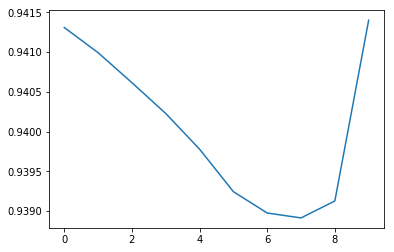

In [2245]:
plt.plot(losses)

In [2209]:
res = txtConv.autoencode(txt,sess)
print(res)
print(txt)

 ни  и  л  т м ый   с и ю ь и    л    м    у   ь у   ы                                              
они минули тёмный вестибюль и вошли в многоугольную высокую залу


In [2210]:
fname = DIRS['RAW_DATA']+'/rus/voxforge_ru/0/00/78d77cdb75be'

In [2211]:
with open(fname+'.txt', 'rb') as f:
    txt = f.read().strip().decode()
txt

'они минули тёмный вестибюль и вошли в многоугольную высокую залу'

In [2212]:
audio = sess.run(sl.load_data([fname+'.wav']))[0]
audio = np.concatenate([audio, [[0,0]]*(60-audio.shape[0]%30)])
audio_resh = audio.reshape((30, -1, 2))

In [2215]:
txt_emb = txtConv.embed(txt, sess)
feed_dict={gru.sound_X:sound_X, gru.txt_embed_plh:txt_emb}

In [2218]:
sparsity_epochs = [5,7,8]
sparsity_lvl = 0.9

In [2236]:
save_period = 8

In [2237]:
losses = []
for epoch in tqdm_notebook(range(10)):
    loss = gru.train(audio_resh, txt_emb, sess)
    losses.append(loss)
    
    if epoch%save_period==0:
        save_path = saver.save(sess, "/tmp/model.ckpt")
    
    if epoch in sparsity_epochs:
        k = gru.calc_sparsity_level(epoch, sparsity_epochs, sparsity_lvl)
        gru.sparsify(k, sess)
        print(f'sparsified by {k}')

sparsified by 0.0
sparsified by 0.8666666666666666
sparsified by 0.9


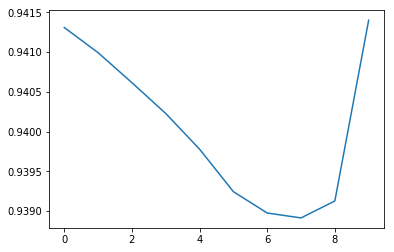

In [2238]:
plt.plot(losses)

In [2239]:
save_path = saver.save(sess, "/tmp/model.ckpt")

In [2248]:
gener_audio = gru.generate_audio(txt_emb, sess, seconds=0.01, show_tqdm=True)

In [2249]:
audio_real = audio*128+128
audio_real = audio_real[:,0]*256+audio_real[:,1]

In [2250]:
txt

'они минули тёмный вестибюль и вошли в многоугольную высокую залу'

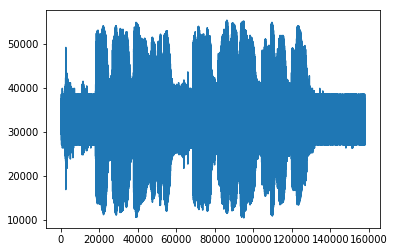

In [2251]:
plt.plot(audio_real)

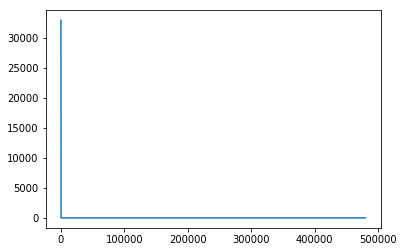

In [2252]:
plt.plot(gener_flat)